In [ ]:
%pip install owslib shapely matplotlib

### Imports

In [ ]:
from owslib.wps import WebProcessingService, ComplexDataInput, monitorExecution
from owslib import wps
import matplotlib
from matplotlib import pyplot
from shapely.geometry import shape
import json
import rasterio
import logging
import sys
import io
from ipyleaflet import Map, GeoJSON, basemaps

In [ ]:
# Set up owslib logging, to set relevant output
logger = logging.getLogger("owslib")
logger.setLevel(logging.WARNING)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.WARNING)
logger.addHandler(handler)

### Consts - Change these to affect the data retrieved

In [ ]:
ENDPOINT="https://funcwps.ternlandscapes.org.au/wps/"
DATASET="aet"  # options are "smips" or "aet"
LAYER="ETa"  # options are "totalbucket" or "SMindex" for smips, or "ETa" for "aet".
ATDATE="2019-01-01"
# Enter your POLYGON as GeoJSON format.
MY_POLYGON='{"type": "Polygon", "coordinates": [[[151.39067721041408, -25.817716701946395], [153.37920260103908, -25.401622912943335], [154.82466059609754, -27.879438356653793], [152.27583247109754, -28.392903179661957], [150.18843012734754, -27.539015050742954], [150.23237543984754, -26.599878666580576], [151.39067721041408, -25.817716701946395]]]}'

### Define a connection to the server

In [ ]:
server = WebProcessingService(ENDPOINT, verbose=False)

In [ ]:
print('WPS Identification type: %s' % server.identification.type)
print('WPS Identification title: %s' % server.identification.title)
print('WPS Identification abstract: %s' % server.identification.abstract)
for operation in server.operations:
    print('WPS Operation: %s' % operation.name)
for process in server.processes:
    print('WPS Process: identifier=%s title=%s' % (process.identifier, process.title))

WPS Identification type: WPS
WPS Identification title: TERN Landscapes Functional Data WPS Server
WPS Identification abstract: The Functional Data Processing Server from TERN Landscapes
WPS Operation: GetCapabilities
WPS Operation: DescribeProcess
WPS Operation: Execute
WPS Process: identifier=sleep title=Sleep Process
WPS Process: identifier=temporalDrill title=Temporal
WPS Process: identifier=subset1d title=SubSet 1D
WPS Process: identifier=subset2d title=SubSet 2D
WPS Process: identifier=stats2d title=Stats 2D


In [ ]:
process = server.describeprocess("subset2d")
print('WPS Process: identifier=%s' % process.identifier)
print('WPS Process: title=%s' % process.title)
print('WPS Process: abstract=%s' % process.abstract)
for input in process.dataInputs:
    print('Process input: identifier=%s, data type=%s, minOccurs=%d, maxOccurs=%d' % (input.identifier, input.dataType, input.minOccurs, input.maxOccurs))
for output in process.processOutputs:
    print('Process output: identifier=%s, data type=%s' % (output.identifier, output.dataType))

WPS Process: identifier=subset2d
WPS Process: title=SubSet 2D
WPS Process: abstract=Return a GeoTiff file containing the dataset subset by the 2D given polygon.
Process input: identifier=datasetId, data type=string, minOccurs=1, maxOccurs=1
Process input: identifier=atDate, data type=date, minOccurs=1, maxOccurs=1
Process input: identifier=polygon, data type=ComplexData, minOccurs=1, maxOccurs=1
Process output: identifier=geotiff, data type=ComplexData
Process output: identifier=download_link, data type=string


### Optional - Visualize shape

In [ ]:
m = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=[-25.128, 135.588], zoom=4)
m.add_layer(GeoJSON(data=json.loads(MY_POLYGON)))
m

Map(center=[-25.128, 135.588], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

### Set up to send request, first create inputs and outputs

In [ ]:
poly_input = ComplexDataInput(MY_POLYGON, mimeType="application/vnd.geo+json", schema="http://geojson.org/geojson-spec.html#polygon")

### Trigger process to begin (process executes asynchronously)

In [ ]:
resp = server.execute(
    "subset2d",
    mode="async",
    inputs=[("datasetId", f"{DATASET}:{LAYER}"), ("polygon", poly_input), ("atDate", ATDATE)],
    output=[("geotiff", True, "image/tiff")]  # Get geotiff file as-reference (link to completed file)
)

### Wait for process to complete (polls every 4 seconds)

In [ ]:
while not resp.isComplete():
    print("Waiting for process to complete...")
    resp.checkStatus(sleepSecs=4)
print("Done")

Waiting for process to complete...
Waiting for process to complete...
Waiting for process to complete...
Waiting for process to complete...
Waiting for process to complete...
Waiting for process to complete...
Waiting for process to complete...
Waiting for process to complete...
Waiting for process to complete...
Done


### Download resulting GeoTiff and save here

In [ ]:
file = resp.getOutput("myfile.tif", identifier="geotiff")
ds = rasterio.open("myfile.tif")

### We can plot it too
#### this can take a while to render if the data field is large.

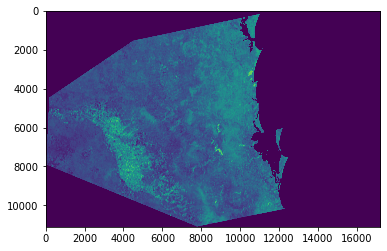

In [ ]:
pyplot.imshow(ds.read(1), cmap='viridis', vmin=0)
ds.close()